Uploading the images provided

In [ ]:
# installing libraries
!pip install --quiet opencv-python-headless scikit-learn

from google.colab.patches import cv2_imshow
import cv2, numpy as np
from itertools import combinations
from sklearn.cluster import DBSCAN

In [ ]:
# 1) Detecting line segments
def detect_line_segments(gray,
                         canny1=50, canny2=150,
                         rho=1, theta=np.pi/180, thresh=100,
                         min_len=80, max_gap=5):
    edges = cv2.Canny(gray, canny1, canny2, apertureSize=3)
    L = cv2.HoughLinesP(edges, rho, theta, thresh,
                        minLineLength=min_len, maxLineGap=max_gap)
    return L.reshape(-1,4) if L is not None else np.zeros((0,4),int)

# 2) detecting intersections
def intersect(l1,l2):
    x1,y1,x2,y2 = l1;  x3,y3,x4,y4 = l2
    A = np.array([[x2-x1, x3-x4],[y2-y1, y3-y4]],float)
    if abs(np.linalg.det(A))<1e-6: return None
    b = np.array([x3-x1, y3-y1],float)
    t,_ = np.linalg.solve(A,b)
    return (x1 + t*(x2-x1), y1 + t*(y2-y1))

def all_intersections(lines, shape):
    h,w = shape[:2]; pts=[]
    for a,b in combinations(lines,2):
        p=intersect(a,b)
        if p is None: continue
        x,y = p
        if -0.1*w<x<1.1*w and -0.1*h<y<1.1*h:
            pts.append(p)
    return np.array(pts)

# 3) Clusteriing the intersections & making the biggest one as VP
def cluster_vp(pts, eps=50, min_samples=15):
    if len(pts)<min_samples:
        return None
    labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(pts)
    # find largest non-noise cluster
    best_label = max(
        (lab for lab in set(labels) if lab>=0),
        key=lambda l: np.sum(labels==l),
        default=None
    )
    if best_label is None: return None
    cluster = pts[labels==best_label]
    return tuple(cluster.mean(axis=0))

# 4) Distance from a point to an infinite line
def point_line_dist(line, pt):
    x1,y1,x2,y2 = line; x0,y0 = pt
    num = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
    den = np.hypot(y2-y1, x2-x1)
    return num/den if den>0 else np.inf

# 5) Removing excess lines
def draw_clean(img, lines, vp, tol=5):
    out = img.copy()
    if vp is not None:
        vx,vy = vp
        for l in lines:
            if point_line_dist(l, (vx,vy)) < tol:
                x1,y1,x2,y2 = l
                cv2.line(out,(x1,y1),(x2,y2),(0,255,0),2,cv2.LINE_AA)
        cv2.circle(out,(int(vx),int(vy)),10,(0,0,255),-1)
    return out

Estimated VP: (np.float64(249.2668961808367), np.float64(160.62919389169565))


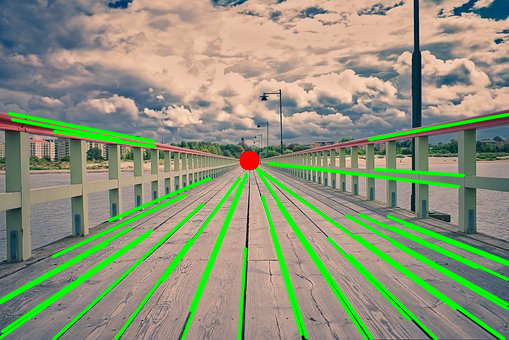

In [ ]:
# ▶️output
IMAGE = "/content/vanishing-point-4468780__340.jpg"
img   = cv2.imread(IMAGE)
gray  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

lines = detect_line_segments(gray)
pts   = all_intersections(lines, img.shape)
vp    = cluster_vp(pts)

print("Estimated VP:", vp)
clean = draw_clean(img, lines, vp, tol=4)
cv2.imwrite("vp_clean.png", clean)
cv2_imshow(clean)